# TP2 - Bandits

Léo Meissner et Héloïse Lafargue

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Objectives:

We want to look at bandits where the rewards are only 1 or 0 (Bernouilli).


1) COMPLETE the code where it says "COMPLETE".

2) Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.

3) Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  
Play with the c parameter in UCB.

4) Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.

5) What are your conclusions in terms of methods? Give some intution.



### Q1

In [ ]:
class BernoulliBanditEnv(object):
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [ ]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.

    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]

        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]

    def environment(self, env, init_q):
        # initialize environment
        self.env = env
        self.k = env.num_arms
        self.actions = np.arange(self.k)
        self.act_count = np.zeros(self.k)
        self.iteration = 0
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])

        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r

    def act(self):
        # action.
        self.iteration += 1
        if self.decision_rule == "greedy":
            # Choose the action with the highest estimated value
            selected_action = np.argmax(self.q_estimate)
            pass

        if self.decision_rule == "epsilon-greedy":
            # With probability ϵ select a random action
            if np.random.rand() < self.epsilon:
                selected_action = np.random.choice(self.actions)
            # With probability 1 − ϵ select a = argmaxa ˆQ(a)
            else:
                selected_action = np.argmax(self.q_estimate)
            pass

        if self.decision_rule == "UCB":
            # Upper Confidence Bound action selection
            confidence_bound = np.sqrt(np.log(self.iteration) / (self.act_count + 1e-5))
            ucb_values = self.q_estimate + self.UCB_param * confidence_bound
            selected_action = np.argmax(ucb_values)
            pass
        if self.decision_rule == "Thompson":
            # Implement Thompson sampling action selection
            sampled_values = np.random.beta(self.alpha, self.beta)
            selected_action = np.argmax(sampled_values)
            pass
        self.act_count[selected_action] += 1
        return selected_action

In [ ]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.

    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0

    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [ ]:
def plot_results(agents, actions, rewards):
    fig, axs = plt.subplots(3, figsize=(6, 10))

    axs[0].set_ylim(0, 1)
    axs[1].set_ylim(0, 1)
    axs[2].set_ylim(0, 1)

    for i, agent in enumerate(agents):
        label=agents[i].decision_rule
        if agent.decision_rule == "UCB":
            label += " c={}".format(agents[i].UCB_param)
        mean_cumulative_reward = [sum(rewards[i][:t + 1]) / (t + 1) for t in range(len(rewards[i]))]
        axs[0].plot(mean_cumulative_reward, label=agents[i].decision_rule)
        axs[1].plot(rewards[i], label=label)
        axs[2].plot(actions[i], label=label)

    axs[0].set_title("Mean Cumulative Reward Over Time")
    axs[0].set_xlabel("Time Step")
    axs[0].set_ylabel("Mean Cumulative Reward")
    axs[0].legend()

    axs[1].set_title("Mean Reward Over Time")
    axs[1].set_xlabel("Time Step")
    axs[1].set_ylabel("Mean Reward")
    axs[1].legend()

    axs[2].set_title("Percentage of Times Best Arm Chosen Over Time")
    axs[2].set_xlabel("Time Step")
    axs[2].set_ylabel("Percentage of Best Arm Choices")
    axs[2].legend()

    plt.tight_layout()
    plt.show()


### Q2

Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.

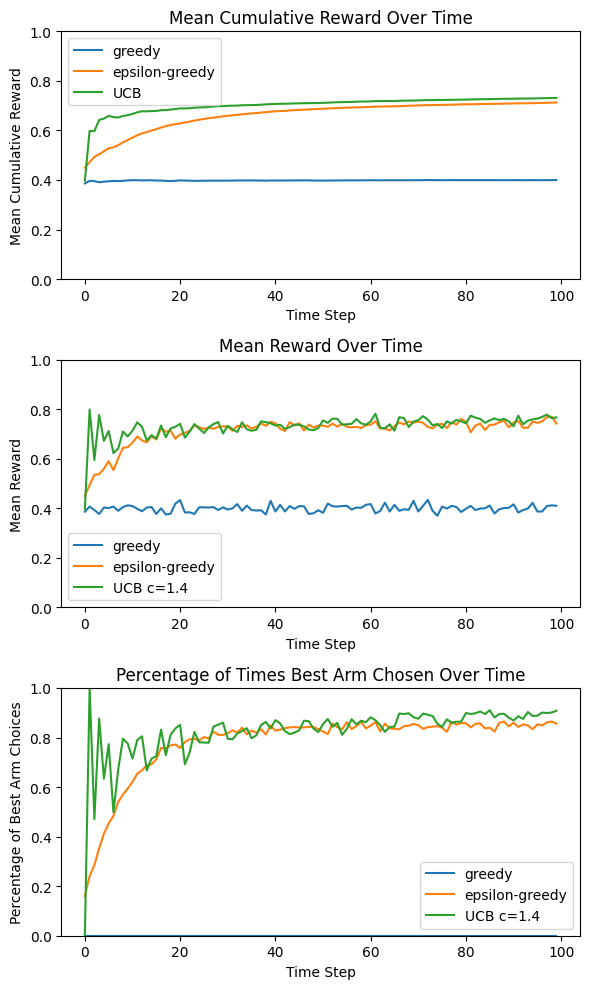

In [ ]:
P = [0.4, 0.8]

agents = [
    Agent(learning_rule="averaging", decision_rule="greedy", param=None),
    Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": 0.3}),
    Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": 1.4}),
]

# Run simulations
rewards, best_arm_counts = simulateBandits(agents, narms=2, initp=P, repetitions=1000, N=100)

# Plot results
plot_results(agents, best_arm_counts, rewards)


Here we can see that the initial parameters mean that the algorithm makes a mistake every time and therefore doesn't find the optimal solution. Epsilon greedy, on the other hand, will converge on the solution as iterations progress, by changing its policy. As there are only 2 arms, we can see that even with a low epsilon, the algorithm will still converge towards the optimal solution. If epsilon is increased (to 0.3, for example), the algorithm will converge more rapidly to this solution.

### Q3

Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  

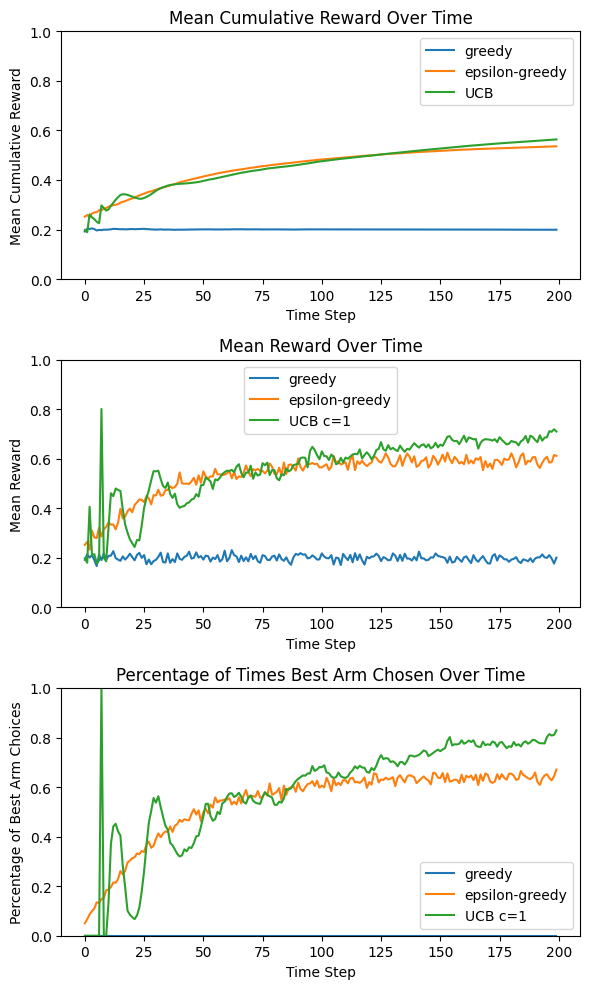

In [ ]:
P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]

agents = [
    Agent(learning_rule="averaging", decision_rule="greedy", param=None),
    Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": 0.4}),
    Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": 1}),
]

# Run simulations
rewards, best_arm_counts = simulateBandits(agents, narms=10, initp=P, repetitions=1000, N=200)

# Plot results
plot_results(agents, best_arm_counts, rewards)


Here, as there are more arms, the epsilon greedy policy fails to converge on the right solution even when increasing epsilon.

Play with the c parameter in UCB.

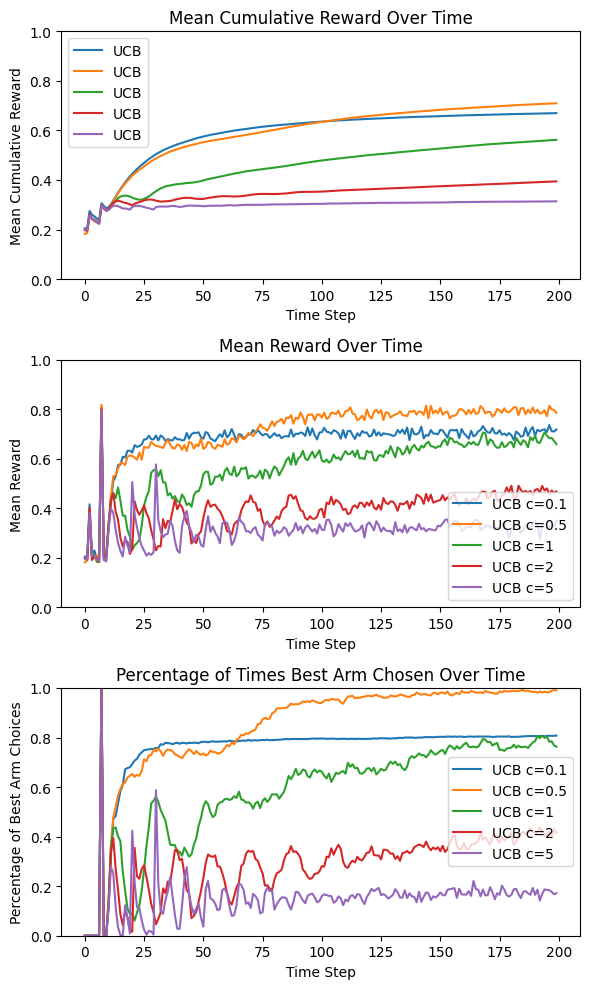

In [ ]:
P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]

c_values = [0.1, 0.5, 1, 2, 5]
agents = []
for c in c_values:
    agents.append(Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": c}))

# Run simulations
rewards, best_arm_counts = simulateBandits(agents, narms=10, initp=P, repetitions=1000, N=200)

# Plot results
plot_results(agents, best_arm_counts, rewards)

The UCB parameter c controls the degree of exploration of the algorithm. When c is large, e.g. c = 5, the algorithm will explore more to test arms that haven't been exploited much yet. The solution therefore converges more slowly when c = 2, and not at all when c = 5. When c is small, e.g. 0.1, the algorithm exploits more and favors the arms that are expected to be the most profitable. Here, algorithms with c = 0.1 and 0.5 quickly converge on the most profitable arm. Finally, c = 1 is generally a happy medium between exploration and exploitation, as can be seen here.

### Q4

Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.

When epsilon is low, the algorithm will mainly exploit the rules that have been given initially. It is therefore very sensitive to initialization, but will converge rapidly if it is close to the optimal solution. As epsilon approaches 0.5, the algorithm will be more robust to initialization, but will converge less rapidly, so there's a happy medium between exploration and exploitation. Finally, when the algorithm is close to 1, it will essentially explore, giving rise to a lot of random choices and tending very slowly towards the ideal policy.

### Q5
What are your conclusions in terms of methods? Give some intution.

Conclusion :

Choosing the right approach for a multi-armed bandit problem depends on the environment's specifics and the balance between exploring new options and exploiting known rewards. Epsilon-greedy offers simplicity, favoring exploitation with a dash of exploration tuned by epsilon. UCB, however, inherently balances the two by considering action value estimates and their uncertainties, with exploration regulated by parameter c. Ultimately, the best strategy varies with the context, demanding a trade-off between computational simplicity and the sophistication needed to maximize long-term gains. Practical application involves iterative tuning and adaptability to the environment's nuances.

## Questions from the pdf that haven't been answered yet

With ε-greedy, what is the asymptotic probability of taking the optimal action?

Which ε is better for a relatively small of T? and for large T

When T is small, you don't have the time to explore a lot. Therefore epsilon should be small to converge faster. When T is large it might be useful to explore more to have a better knowledge of the environment.

Do you observe some spikes in the plot of average rewards? if yes, please provide an explanation.

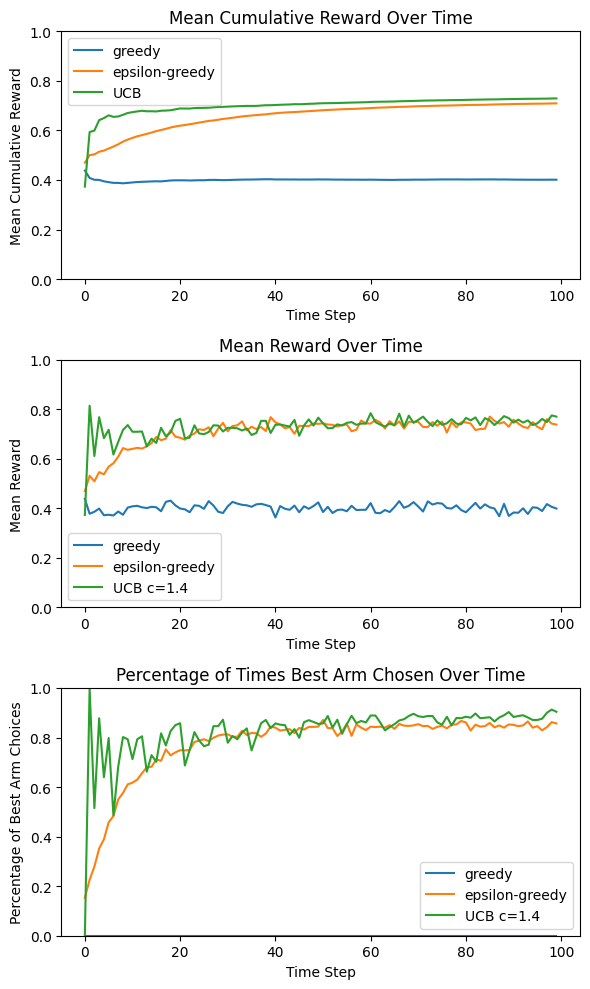

In [ ]:
P = [0.4, 0.8]

agents = [
    Agent(learning_rule="averaging", decision_rule="greedy", param=None),
    Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": 0.3}),
    Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": 1.4}),
]

# Run simulations
rewards, best_arm_counts = simulateBandits(agents, narms=2, initp=P, repetitions=1000, N=100)

# Plot results
plot_results(agents, best_arm_counts, rewards)

We can see observe some spikes in every simulations. Despite the policy choosen by every algorithm, it is still statistics. Sometimes the algorithm will win a little more or lose a little more over the 1000 repetitions.

## Gradient method

Implement the gradient bandit algorithm. Consider the same experiment setting as above, but with a reward of 4 instead of 1.

Consider both cases, with a baseline R ̄ = 0, and R ̄ = 4 × maxk pk. Consider different values of the alpha parameter αn = α0/n.

As performance measure, consider as above the mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by.

Questions:
1. Which method does work better, with or without baseline?
2. How does the performance of the gradient method compares to the other?

In [ ]:
class Agent(object):

    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "gradient":
          self.alpha = param["alpha"]

    def environment(self, env, init_q):
        # initialize environment
        self.env = env
        self.k = env.num_arms
        self.actions = np.arange(self.k)
        self.act_count = np.zeros(self.k)
        self.rewards = np.zeros(self.k)
        self.iteration = 0
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))
        # Gradient
        self.H = np.zeros(self.k) # preference for each action
        self.pi = np.exp(self.H) / np.sum(np.exp(self.H))  # softmax probability for each action


    def learn(self, a, r, baseline):
        if self.learning_rule == "gradient":
            one_hot = np.zeros(self.k)
            one_hot[a] = 1
            self.H += self.alpha * (r - baseline) * (one_hot - self.pi)

    def act(self):
        self.iteration += 1
        if self.decision_rule == "gradient":
          selected_action = np.random.choice(self.actions, p=self.pi)
          self.act_count[selected_action] += 1
          self.alpha /= self.act_count[selected_action]
        return selected_action

    def softmax(self):
      exp_preferences = np.exp(self.H)
      return exp_preferences / np.sum(exp_preferences)

In [ ]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100, baseline=None):
    # function that simulates the agents behaviour
    # agents is a list of agents.

    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r, baseline)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0

    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [ ]:
def plot_results_agent(agent, actions, rewards):
    fig, axs = plt.subplots(3, figsize=(6, 10))

    axs[0].set_ylim(0, 1)
    axs[1].set_ylim(0, 1)
    axs[2].set_ylim(0, 1)

    mean_cumulative_reward = [sum(rewards[:t + 1]) / (t + 1) for t in range(len(rewards))]
    axs[0].plot(mean_cumulative_reward, label=agent.decision_rule)
    axs[1].plot(rewards, label=agent.decision_rule)
    axs[2].plot(actions, label=agent.decision_rule)

    axs[0].set_title("Mean Cumulative Reward Over Time")
    axs[0].set_xlabel("Time Step")
    axs[0].set_ylabel("Mean Cumulative Reward")
    axs[0].legend()

    axs[1].set_title("Mean Reward Over Time")
    axs[1].set_xlabel("Time Step")
    axs[1].set_ylabel("Mean Reward")
    axs[1].legend()

    axs[2].set_title("Percentage of Times Best Arm Chosen Over Time")
    axs[2].set_xlabel("Time Step")
    axs[2].set_ylabel("Percentage of Best Arm Choices")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

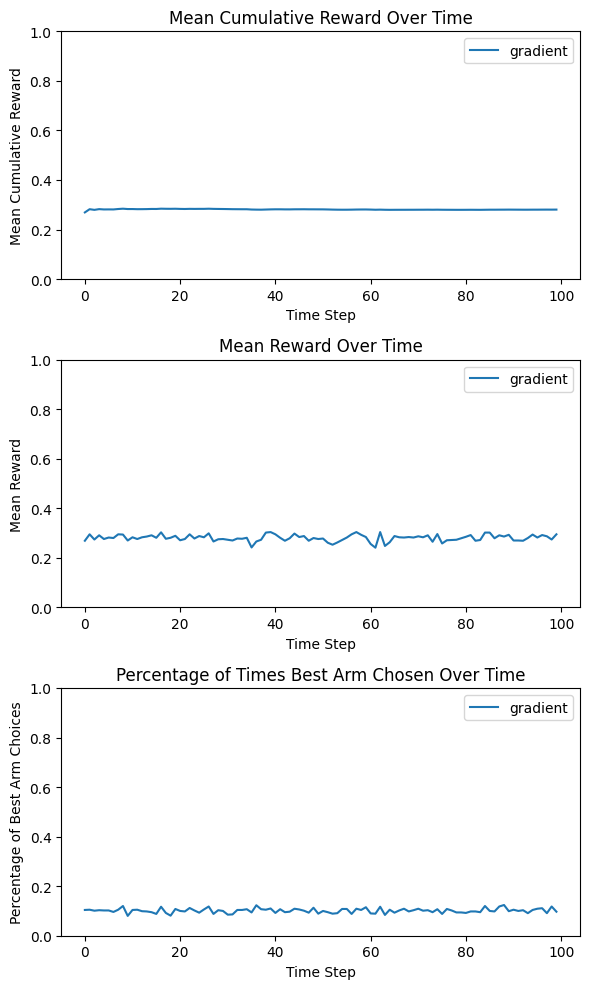

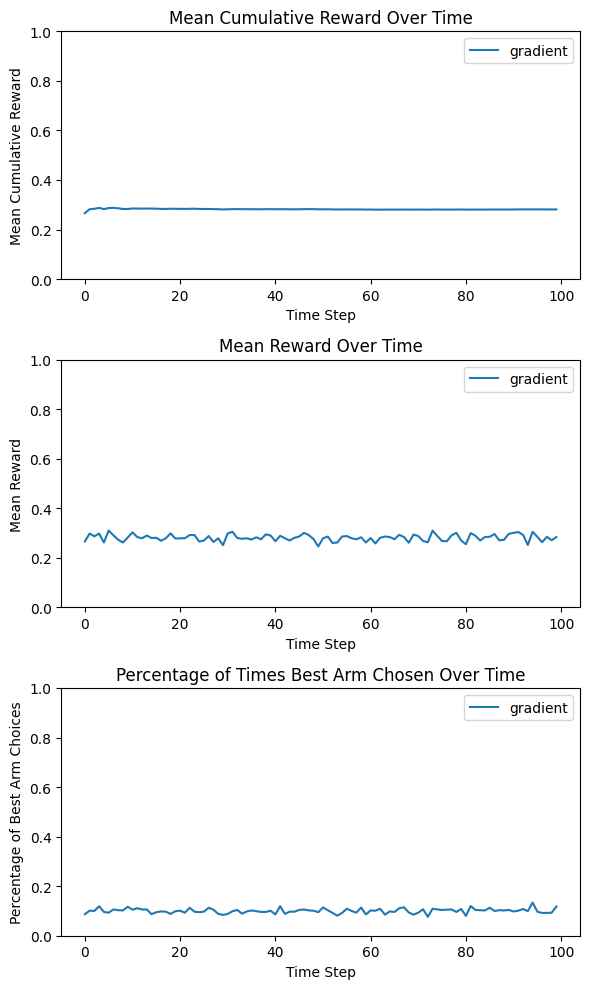

In [ ]:
# Set the parameters for the experiment
num_arms = 10
probabilities = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]
alpha = 0.1  # Starting learning rate

# Initialize the agents with and without baseline
agent_with_baseline = Agent(decision_rule="gradient", learning_rule="gradient", param={"alpha": alpha})
agent_without_baseline = Agent(decision_rule="gradient", learning_rule="gradient", param={"alpha": alpha})

# Run simulations for both agents with and without baseline
rewards_with_baseline, best_arm_with_baseline = simulateBandits([agent_with_baseline], num_arms, probabilities, repetitions=1000, N=100, baseline=4 * max(probabilities))
rewards_without_baseline, best_arm_without_baseline = simulateBandits([agent_without_baseline], num_arms, probabilities, repetitions=1000, N=100, baseline=0)

# Plot the results using the plot_results function
plot_results_agent(agent_with_baseline, best_arm_with_baseline, rewards_with_baseline)
plot_results_agent(agent_without_baseline, best_arm_without_baseline, rewards_without_baseline)
